In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm


# Data analysis

In [53]:
df = pd.read_csv('./datasets/all_steps_test_paper.csv')
#df = pd.read_csv('./datasets/all_steps.csv')
tgn = 2
df = df.loc[df['tangram nr' ] ==tgn]

#this removes steps that are outside the grid (backtracks)
df=df[df.step != 100]


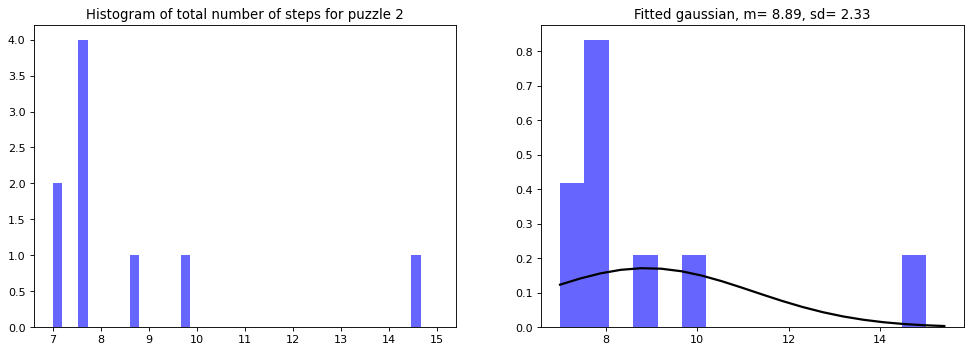

In [54]:
#df = pd.read_csv('./datasets/steps_test.csv')


participants = df.groupby(['sid','tangram nr']).max()['step'].to_numpy()

data = participants
plt.figure(figsize=(15, 5), dpi=80)
ax = plt.subplot(121)
ax.set_title(f'Histogram of total number of steps for puzzle {tgn}')
# H, bins = np.histogram(data,bins=int(np.max(data)))

# ax.bar(bins[:-1],H,width=0.5)
ax.hist(data, bins=int(np.max(participants)), alpha=0.6, width=0.2, color='b')
ax = plt.subplot(122)
mu, std = norm.fit(data)

ax.hist(data, bins=int(np.max(participants)), density=True,stacked=True, alpha=0.6, color='b')
xmin, xmax = (7,plt.xlim()[1])
x = np.linspace(xmin, xmax, 20)
p = norm.pdf(x, mu, std)
ax.set_title('Fitted gaussian, m= {:.2f}, sd= {:.2f}'.format(mu,std))
plt.plot(x, p, 'k', linewidth=2)
plt.show()

In [55]:
print('participants pre-trim')
print(f'mean: {participants.mean()}, std: {participants.std()}, max: {participants.max()}')
participants = participants[participants<participants.mean()+3*participants.std()]
print('participants')
l = len(participants)
print('n:%d'%l)
print(f'mean: {participants.mean()}, std: {participants.std()}, max: {participants.max()}')
print('perfect solutions: %.2f'%(np.count_nonzero(participants == 7)/l))
print(np.count_nonzero(participants == 7))

participants pre-trim
mean: 8.88888888888889, std: 2.3306863292670035, max: 15.0
participants
n:9
mean: 8.88888888888889, std: 2.3306863292670035, max: 15.0
perfect solutions: 0.22
2


# General stats
Avg number of steps, std...

In [70]:
def print_results_1(tgn):
    print(tgn)
    test_data = np.loadtxt(f'datasets/heatmap{tgn}_test.txt')
    train_data = np.loadtxt(f'datasets/heatmap{tgn}.txt')
    #data = np.loadtxt(f'datasets/heatmap{tgn}.txt')
    test_data = np.flip(test_data/test_data.sum(axis=0,keepdims=1),axis=0)
    train_data = np.flip(train_data/train_data.sum(axis=0,keepdims=1),axis=0)
    heatmaps = []
    heatmaps.append(train_data)
    heatmaps.append(test_data)

    for restype in ['balanced','freq','vision']:
        mat = pd.read_csv(f"results/heatmap_{tgn}_{restype}_cnt.csv",header=None).to_numpy()
        solved_at = (mat==0).argmax(axis=1)
        solved_at[solved_at==0] = mat.shape[1] 

        heatmap = np.zeros((5,10))
        for i in range(5):
            p = i+1
            for m in range(10):
                heatmap[i,m] = np.count_nonzero(mat[:,m] == p)
        heatmaps.append(heatmap/heatmap.sum(axis=0,keepdims=1))
        print(f'{restype} -- mean: {solved_at.mean()}, std: {solved_at.std()}, perfect: {np.count_nonzero(solved_at == 7)}:{np.count_nonzero(solved_at == 7)/31}')
        
    fig, axs = plt.subplots(5,1, figsize = (4,20))
    cmap = sns.cm.rocket_r



    for hm,ax,name in zip(heatmaps,axs.flatten(),['training data','test data','balanced','freq','vision']):
        y_axis_labels = ['small triangle','square','parall','middle triangle','big triangle']
        x_axis_labels = [1,2,3,4,5,6,7,8,9,10]
        ax.set_title(name)

        rmse =np.sqrt(np.mean((hm-train_data)**2, axis=0))
        print(f'{name}: {np.mean(rmse)}')

        sns.heatmap(hm,ax=ax,yticklabels=y_axis_labels,xticklabels=x_axis_labels,cmap=cmap,vmin=0, vmax=1)
        ax.invert_yaxis()
    plt.show()

2
balanced -- mean: 10.833333333333334, std: 5.441098745249488, perfect: 10:0.3225806451612903
freq -- mean: 10.266666666666667, std: 5.0985836813330385, perfect: 15:0.4838709677419355
vision -- mean: 10.2, std: 5.455272678794342, perfect: 18:0.5806451612903226
training data: 0.0
test data: 0.13667321810272096
balanced: 0.13606477655088417
freq: 0.14676643386082894
vision: 0.11677991740630245


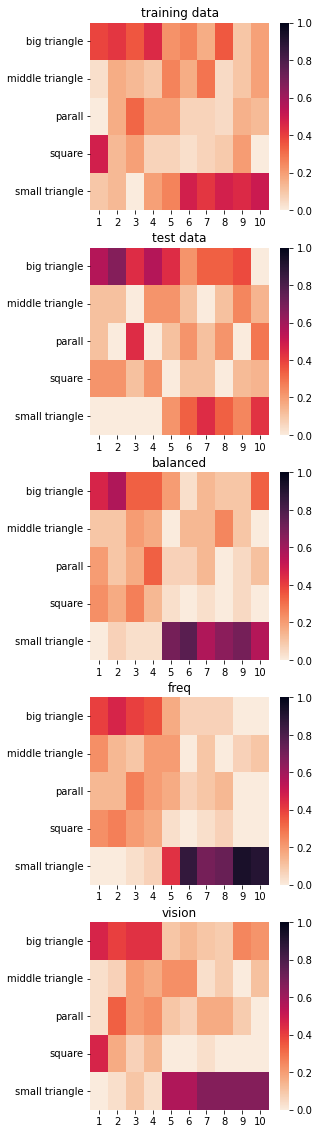

In [75]:
print_results_1(2)

In [73]:
def rot_normalize(pos,piece='square'):
    # normalize position of square and parall
    if pos == 'set()':
        return pos
    else:
        print(pos)
        pos = list(eval(pos))[0][1]
    rot = pos[1]
    if piece =='square':
        if rot% 90 == 0:
            return (pos[0],0)
        else:
            return (pos[0],45)
        
    if piece == 'parall':
        if rot == 180:
            return (pos[0],0)
        if rot == 225:
            return (pos[0],45)
        if rot == 270:
            return (pos[0],90)
        if rot == 315:
            return (pos[0],135)
    return pos

tgn = 4
users = pd.read_csv('datasets/test_states.csv')
#users = pd.read_csv('datasets/train_states.csv')
users = users.loc[users['tangram nr'] ==tgn]
for mtype in ['balanced','freq','vision']:
    model = pd.read_csv(f'results/model_states_evolution_{tgn}_{mtype}_cnt.csv')

    limits = {2:int(10.8+6.9),4:int(12.4+6.5)}
    offset = [1,2,3,3,3]
    score = 0
    max_score = 0
    errors= 0
    for run in model.run.unique():
        run_steps = model.loc[model.run == run]
        if len(run_steps) < 17:
            errors+=1
            continue
        for step in range(3,limits.get(tgn)):


            state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
            previous = run_steps.iloc[step-2][['small triangle','middle triangle','big triangle','square','parallelogram']]
            last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
            if not (state.equals(last_state) and state.equals(previous)):
                max_score +=1
                users_at_step = users.loc[users['step'].isin(list(range(step-offset[step//4], step + offset[step//4]+1)))][['small triangle','middle triangle','big triangle','square','parallelogram']]
                res= users_at_step.loc[
                    (users_at_step['small triangle'] == state['small triangle']) &
                    (users_at_step['middle triangle'] == state['middle triangle']) &
                    (users_at_step['big triangle'] == state['big triangle']) &
                    (users_at_step['square']== state['square']) &
                    (users_at_step['parallelogram'] == state['parallelogram'])
                ]
                if not res.empty:
                    score+=1
    print(f'model: {mtype}')
    print(f'score: {score} / {max_score}')
    print(f'\t={score/max_score}')


model: balanced
score: 45 / 243
	=0.18518518518518517
model: freq
score: 35 / 217
	=0.16129032258064516
model: vision
score: 51 / 257
	=0.19844357976653695


In [51]:
#users_at_step['square'].apply(lambda x: 0 if x =='set()' else list(eval(x))[])
users_at_step.head(40)

,small triangle,middle triangle,big triangle,square,parallelogram
55,"{(11.0, 0.0)}",set(),"{(12.0, 135.0)}","{(23.0, 0.0)}",set()
56,set(),set(),"{(12.0, 135.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
57,set(),set(),"{(12.0, 135.0), (7.0, 45.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
58,set(),"{(7.0, 225.0)}","{(12.0, 135.0), (7.0, 45.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
59,"{(23.0, 0.0)}","{(7.0, 225.0)}","{(12.0, 135.0), (7.0, 45.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
60,"{(23.0, 0.0), (2.0, 135.0)}","{(7.0, 225.0)}","{(12.0, 135.0), (7.0, 45.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
61,"{(23.0, 0.0), (2.0, 135.0)}","{(7.0, 225.0)}","{(12.0, 135.0), (7.0, 45.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
119,"{(23.0, 0.0), (2.0, 135.0)}",set(),set(),"{(23.0, 0.0)}","{(11.0, 90.0)}"
120,"{(23.0, 0.0), (2.0, 135.0)}",set(),"{(13.0, 270.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
121,"{(23.0, 0.0), (2.0, 135.0)}",set(),set(),set(),set()


In [62]:
state

small triangle      {(23.0, 0.0), (2.0, 135.0)}
middle triangle                  {(8.0, 225.0)}
big triangle       {(17.0, 135.0), (7.0, 45.0)}
square                            {(23.0, 0.0)}
parallelogram                    {(11.0, 90.0)}
Name: 512, dtype: object

# Heatmaps

0.0
0.13606477655088417
0.14676643386082894
0.11677991740630245


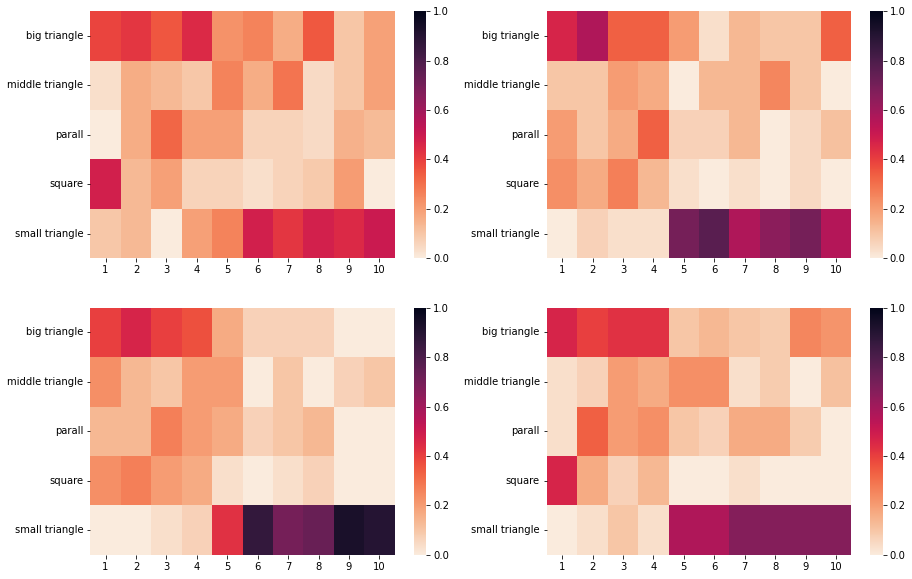

In [85]:
fig, axs = plt.subplots(2,2, figsize = (15,10))
cmap = sns.cm.rocket_r



for hm,ax in zip(heatmaps,axs.flatten()):
    y_axis_labels = ['small triangle','square','parall','middle triangle','big triangle']
    x_axis_labels = [1,2,3,4,5,6,7,8,9,10]
    
    rmse =np.sqrt(np.mean((hm-data)**2, axis=0))
    print(np.mean(rmse))

    sns.heatmap(hm,ax=ax,yticklabels=y_axis_labels,xticklabels=x_axis_labels,cmap=cmap,vmin=0, vmax=1)
    ax.invert_yaxis()
plt.show()

In [84]:
tgn = 2

#mat = pd.read_csv("results/heatmap_2_mixed_cnt.csv",header=None).to_numpy()
data = np.loadtxt(f'datasets/heatmap{tgn}.txt')
data = np.flip(data/data.sum(axis=0,keepdims=1),axis=0)
heatmaps = []
heatmaps.append(data)

for restype in ['balanced','freq','vision']:
    mat = pd.read_csv(f"results/heatmap_{tgn}_{restype}_cnt.csv",header=None).to_numpy()
    solved_at = (mat==0).argmax(axis=1)
    solved_at[solved_at==0] = mat.shape[1] 
    
    heatmap = np.zeros((5,10))
    for i in range(5):
        p = i+1
        for m in range(10):
            heatmap[i,m] = np.count_nonzero(mat[:,m] == p)
    heatmaps.append(heatmap/heatmap.sum(axis=0,keepdims=1))
    print(f'{restype} -- mean: {solved_at.mean()}, std: {solved_at.std()}, perfect: {np.count_nonzero(solved_at == 7)}')

balanced -- mean: 10.833333333333334, std: 5.441098745249488, perfect: 10
freq -- mean: 10.266666666666667, std: 5.0985836813330385, perfect: 15
vision -- mean: 10.2, std: 5.455272678794342, perfect: 18


In [19]:
heatmap = np.zeros((5,10))
for i in range(5):
    p = i+1
    for m in range(10):
        heatmap[i,m] = np.count_nonzero(mat[:,m] == p)


In [20]:
heatmap = heatmap/heatmap.sum(axis=0,keepdims=1)

In [44]:
data = np.loadtxt('datasets/heatmap2.txt')

In [45]:
rmse =np.sqrt(np.mean((heatmap-data)**2, axis=0))
print(rmse)

[0.36863816 0.22625353 0.23309983 0.2217245  0.22136753 0.23856336
 0.2949045  0.23439537 0.28828998 0.27198828]


In [46]:
np.mean(rmse)

0.2599225028453273

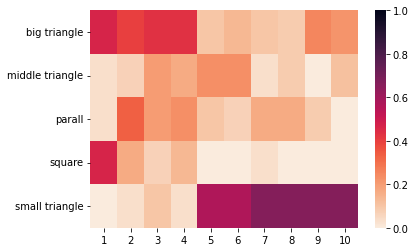

In [50]:
cmap = sns.cm.rocket_r
y_axis_labels = ['small triangle','square','parall','middle triangle','big triangle']
x_axis_labels = [1,2,3,4,5,6,7,8,9,10]
fig, ax = plt.subplots()
sns.heatmap(heatmap,ax=ax,yticklabels=y_axis_labels,xticklabels=x_axis_labels,cmap=cmap,vmin=0, vmax=1)
ax.invert_yaxis()
plt.show()


# Sequence evaluation

Tangram 2

In [32]:
tgn = 2
users = pd.read_csv('datasets/train_states.csv')
users = users.loc[users['tangram nr'] ==tgn]
model = pd.read_csv(f'results/model_states_evolution_{tgn}_only_data_cnt.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'results/model_states_evolution_2_only_data_cnt.csv'

## Method1: step-by-step matching

For each run, the model gets its score by comparing the position at each step with user data at step +-1, scoring 1 point if there is any match

In [31]:
limits = {2:int(10.8+6.9),4:int(12.4+6.5)}
offset = [1,2,3,3,3]
score = 0
max_score = 0
errors= 0
for run in model.run.unique():
    run_steps = model.loc[model.run == run]
    if len(run_steps) < 17:
        errors+=1
        continue
    for step in range(3,limits.get(tgn)):
        
        
        state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        previous = run_steps.iloc[step-2][['small triangle','middle triangle','big triangle','square','parallelogram']]
        last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        if not (state.equals(last_state) and state.equals(previous)):
            max_score +=1
            users_at_step = users.loc[users['step'].isin(list(range(step-offset[step//4], step + offset[step//4]+1)))][['small triangle','middle triangle','big triangle','square','parallelogram']]
            res= users_at_step.loc[
                (users_at_step['small triangle'] == state['small triangle']) &
                (users_at_step['middle triangle'] == state['middle triangle']) &
                (users_at_step['big triangle'] == state['big triangle']) &
                (users_at_step['square'] == state['square']) &
                (users_at_step['parallelogram'] == state['parallelogram'])
            ]
            if not res.empty:
                score+=1
print(score)
print(max_score)
print(score/max_score)
print(errors)

NameError: name 'model' is not defined

In [221]:
score = 0
max_score = 0
for run in model.run.unique():
    run_steps = model.loc[model.run == run]
    for step in range(3,12):
        state = run_steps.iloc[step][['small triangle','middle triangle','big triangle','square','parallelogram']]
        previous = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        if not (state.equals(last_state) and state.equals(previous)):
            max_score +=1
            users_at_step = users.loc[users['step'].isin([step-1,step,step+1])][['small triangle','middle triangle','big triangle','square','parallelogram']]
            res= users_at_step.loc[
                (users_at_step['small triangle'] == state['small triangle']) &
                (users_at_step['middle triangle'] == state['middle triangle']) &
                (users_at_step['big triangle'] == state['big triangle']) &
                (users_at_step['square'] == state['square']) &
                (users_at_step['parallelogram'] == state['parallelogram'])
            ]
            if not res.empty:
                score+=1
print(score)
print(max_score)
print(score/max_score)

IndexError: single positional indexer is out-of-bounds

## Method1: rms

In [166]:
def state_diff(model,user):
    diff = 0
    for c in ['small triangle','middle triangle','big triangle','square','parallelogram']:
        if user[c] != model[c]:
            diff +=1
    return diff



errors = 10*np.ones((len(model.run.unique()),13))
for run in model.run.unique():
    run_steps = model.loc[model.run == run]
    for step in range(3,16):
        
        state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        previous = run_steps.iloc[step-2][['small triangle','middle triangle','big triangle','square','parallelogram']]
        last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        if not (state.equals(last_state) and state.equals(previous)):
            max_score +=1
            users_at_step = users.loc[users['step']==step][['small triangle','middle triangle','big triangle','square','parallelogram']]
            res = users_at_step.apply(lambda x: state_diff(state,x),axis=1)
            rmse = np.sqrt(np.mean((res)**2))
            errors[run,step-3] = rmse
#             res= users_at_step.loc[
#                 (users_at_step['small triangle'] == state['small triangle']) &
#                 (users_at_step['middle triangle'] == state['middle triangle']) &
#                 (users_at_step['big triangle'] == state['big triangle']) &
#                 (users_at_step['square'] == state['square']) &
#                 (users_at_step['parallelogram'] == state['parallelogram'])
#             ]


errors.min(axis=0)

array([2.29492193, 2.40138849, 2.20605228, 2.18326972, 2.34520788,
       2.20605228, 2.30940108, 2.10554823, 1.97484177, 2.25831796,
       2.20605228, 2.04939015, 2.01659779])

In [160]:
def state_diff(model,user):
    diff = 0
    for c in ['small triangle','middle triangle','big triangle','square','parallelogram']:
        if user[c] != model[c]:
            diff +=1
    return diff


score = 0
max_score = 0
errors = 10*np.ones((len(model.run.unique()),13))
for run in model.run.unique():
    run_steps = model.loc[model.run == run]
    for step in range(3,16):
        
        state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        previous = run_steps.iloc[step-2][['small triangle','middle triangle','big triangle','square','parallelogram']]
        last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        if not (state.equals(last_state) and state.equals(previous)):
            max_score +=1
            users_at_step = users.loc[users['step']==step][['small triangle','middle triangle','big triangle','square','parallelogram']]
            res = users_at_step.apply(lambda x: state_diff(state,x),axis=1)
            errors[run,step-3] = min(res)
            if not res.empty:
                score+=1
print(score)
print(max_score)
 
print(score/max_score)

errors

305
305
1.0


array([[ 0.,  1.,  0.,  1.,  0.,  0., 10., 10., 10., 10., 10., 10., 10.],
       [ 1.,  1.,  1.,  2.,  2.,  2.,  1.,  2.,  1.,  0.,  0., 10., 10.],
       [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  2.,  2.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  1.,  1.,  2.,  1.,  1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0., 10.],
       [ 1.,  2.,  0.,  1.,  0.,  0., 10., 10., 10., 10., 10., 10., 10.],
       [ 0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  2.,  2.,  1.],
       [ 1.,  2.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
       [ 1.,  1.,  1.,  2.,  2.,  1.,  2.,  2.,  2.,  1.,  0., 10., 10.],
       [ 2.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  0., 10., 10., 10.],
       [ 1.,  0.,  1.,  2.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.],
       [ 1.,  1.,  1.,  0.,  1.,  1., 

In [74]:
step=3
users_at_step = users.loc[users['step']==step][['small triangle','middle triangle','big triangle','square','parallelogram']]
run_steps=  model.loc[model.run == 1]
state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]



## Method2: phase-by-phase matching

For each run, the results is matched at step 4, 8 and 12, getting incremental points if such sequence also appears in participants data, some margin or error is accepted

In [72]:
score=0
same_seq= 0
for run in model.run.unique():

    run_steps = model.loc[model.run == run]
    
    #step 4
    step=4
    model_at_step = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
    users_at_step = users.loc[users['step'].isin(range(step-1,step+2))]
    res= users_at_step.loc[
                (users_at_step['small triangle'] == model_at_step['small triangle']) &
                (users_at_step['middle triangle'] == model_at_step['middle triangle']) &
                (users_at_step['big triangle'] == model_at_step['big triangle']) &
                (users_at_step['square'] == model_at_step['square']) &
                (users_at_step['parallelogram'] == model_at_step['parallelogram'])
            ]
    if res.empty:
        
        continue
    
    score +=1
    filtered=  users.loc[users['sid'].isin(res.sid.unique())]
    
    #step 8
    step = 8
    model_at_step = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
    users_at_step = users.loc[users['step'].isin(range(step-2,step+3))]
    res= users_at_step.loc[
                (users_at_step['small triangle'] == model_at_step['small triangle']) &
                (users_at_step['middle triangle'] == model_at_step['middle triangle']) &
                (users_at_step['big triangle'] == model_at_step['big triangle']) &
                (users_at_step['square'] == model_at_step['square']) &
                (users_at_step['parallelogram'] == model_at_step['parallelogram'])
            ]
    if res.empty:
        
        continue
    
    score +=2
    filtered=  users.loc[users['sid'].isin(res.sid.unique())]
    
#     step 8
    step = 12
    model_at_step = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
    users_at_step = users.loc[users['step'].isin(range(step-3,step+4))]
    res= users_at_step.loc[
                (users_at_step['small triangle'] == model_at_step['small triangle']) &
                (users_at_step['middle triangle'] == model_at_step['middle triangle']) &
                (users_at_step['big triangle'] == model_at_step['big triangle']) &
                (users_at_step['square'] == model_at_step['square']) &
                (users_at_step['parallelogram'] == model_at_step['parallelogram'])
            ]
    if res.empty:
        
        continue
    
    score +=3
    same_seq +=1
    filtered=  users.loc[users['sid'].isin(res.sid.unique())]

print(score)
print(same_seq)

16
2
